In [1]:
import os
import re
import glob
import subprocess
import numpy as np
import nglview as nv
import MDAnalysis as mda
import gmxapi as gmx
from math import degrees 
from math import atan2 
import itertools

from MDAnalysis.transformations.rotate import rotateby
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align

In [2]:
import seaborn as sns
import json
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context(font_scale=3,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

In [3]:
def reorder_chain_anticlock_wise(u, nineprime):
    def get_angle(p1, p2, p3):
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        deg1 = (360 + degrees(atan2(x1 - x2, y1 - y2))) % 360
        deg2 = (360 + degrees(atan2(x3 - x2, y3 - y2))) % 360
        return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

    if u.select_atoms(nineprime).positions[0][2] - u.select_atoms('resid 120').positions[0][2] <= 0:
        # orientation wrong rotate
        u.trajectory.add_transformations(rotateby(180, [0,1,0], ag=u.atoms))
        
    ordered_chain_dic = {}
    seg_0 = u.atoms.segments[0]
    ordered_chain_dic['A'] = seg_0
    seg_1 = u.atoms.segments[1]
    seg_2 = u.atoms.segments[2]
    seg_3 = u.atoms.segments[3]
    seg_4 = u.atoms.segments[4]
    seg_list = [seg_1, seg_2, seg_3, seg_4]

    princ_axis = u.atoms.center_of_mass()[:2]

    angle_list = []
    angle_list.append(get_angle(seg_0.atoms.center_of_mass()[:2], princ_axis, seg_1.atoms.center_of_mass()[:2]))
    angle_list.append(get_angle(seg_0.atoms.center_of_mass()[:2], princ_axis, seg_2.atoms.center_of_mass()[:2]))
    angle_list.append(get_angle(seg_0.atoms.center_of_mass()[:2], princ_axis, seg_3.atoms.center_of_mass()[:2]))
    angle_list.append(get_angle(seg_0.atoms.center_of_mass()[:2], princ_axis, seg_4.atoms.center_of_mass()[:2]))
    
    order_list = np.argsort(angle_list)
    ordered_chain_dic['B'] = seg_list[order_list[0]]
    ordered_chain_dic['C'] = seg_list[order_list[1]]
    ordered_chain_dic['D'] = seg_list[order_list[2]]
    ordered_chain_dic['E'] = seg_list[order_list[3]]
    
    for seg_fixed, seg_old in ordered_chain_dic.items():
#        print(seg_fixed, seg_old)
        seg_old.segid = seg_fixed
    u.atoms.chainIDs = u.atoms.segids
    return u

In [4]:
def clean_up_and_chap(pdb_file, nineprime, get_chap=False):
    print(pdb_file)
    output_name = 'rank' + pdb_file.split('_')[2]
    try:
        os.mkdir(location + '/chap')
    except:
        print('')

    gmx_run = gmx.commandline_operation('gmx',
                          ['editconf', '-princ'],
                          input_files={
                                '-f': pdb_file,
                          },
                          output_files={
                                '-o': location + '/chap/' + output_name + '.pdb' 
                          },
                         stdin='2\n'
                         )
    gmx_run.run()
    if gmx_run.output.returncode.result() != 0:
        print(gmx_run.output.erroroutput.result())
    gmx_run = gmx.commandline_operation('gmx',
                          ['editconf', '-rotate', '0', '-90', '0'],
                          input_files={
                                '-f': location + '/chap/' + output_name + '.pdb',
                          },
                          output_files={
                                '-o': location + '/chap/' + output_name + '.pdb' 
                          }
                         )
    gmx_run.run()
    if gmx_run.output.returncode.result() != 0:
        print(gmx_run.output.erroroutput.result())
    u = mda.Universe(location + '/chap/' + output_name + '.pdb')
    u = reorder_chain_anticlock_wise(u, nineprime)
    u.select_atoms('prop resid > 25 and not element H').sort(key='segids').write(location + '/chap/' + output_name + '.ordered.pdb')
    u.select_atoms('prop resid > 25 and not element H').sort(key='segids').write(location + '/' + output_name + '.ordered.pdb')
    if get_chap:
        ninepos = np.mean(u.select_atoms(nineprime).positions, axis=0) / 10
        chap_command = ['/nethome/yzhuang/msm/alpha_fold/notebook/run_chap.sh', location, output_name, '{:.2f}'.format(ninepos[0]), '{:.2f}'.format(ninepos[1]), '{:.2f}'.format(ninepos[2])]
        print(chap_command)
        process = subprocess.Popen(chap_command,
                                 stdin=subprocess.PIPE,
                                 stdout=subprocess.PIPE, 
                                 stderr=subprocess.PIPE,
                                 universal_newlines=True,
                                 bufsize=0,
                                 cwd='/nethome/yzhuang/msm/alpha_fold/notebook/' + location + 'chap')
        process.stdin.write("1\n")
        process.stdin.close()

        for line in process.stdout:
            print(line.strip())
        for line in process.stderr:
            print(line.strip())
        
    return (location + '/' + output_name + '.ordered.pdb')
    

In [5]:
def draw_pore_radius(location):
    struc_jsons = []
    for rank in range(1,6):
        with open(location + 'chap/rank' + str(rank) + '.prot.json') as file:
            struc_jsons.append(json.load(file))

    fig, ax = plt.subplots(figsize = (8,14))

    for i, struc_json in enumerate(struc_jsons):
        ax.plot(np.array(struc_json["pathwayProfile"]["radiusMean"]) * 10,
                np.array(struc_json["pathwayProfile"]["s"]), linewidth=4, label='rank' + str(i+1)
                )

    ax.set_xlim(0,15)
    ax.set_ylim(-10,15)
    ax.set_xlabel('Radius (Å)')
    ax.set_ylabel('Distance along pore (nm)')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.xaxis.set_tick_params(width=4)
    ax.yaxis.set_tick_params(width=4)
    ax.legend()

In [6]:
def draw_pair_rmsd(u_ensemble):
    confident_residues = set.intersection(
            set(u_ensemble[0].select_atoms('name CA and prop tempfactor > 70').resindices),
            set(u_ensemble[1].select_atoms('name CA and prop tempfactor > 70').resindices),
            set(u_ensemble[2].select_atoms('name CA and prop tempfactor > 70').resindices),
            set(u_ensemble[3].select_atoms('name CA and prop tempfactor > 70').resindices),
            set(u_ensemble[4].select_atoms('name CA and prop tempfactor > 70').resindices)
        )

    prmsd = np.zeros((len(u_ensemble), 
                      len(u_ensemble))).ravel()
    for i, (u1, u2) in enumerate(itertools.product(u_ensemble, repeat=2)):
        r = rmsd(u1.select_atoms('group confident_resid', confident_resid=u_ensemble[0].select_atoms('name CA')[list(confident_residues)]).positions,
                 u2.select_atoms('group confident_resid', confident_resid=u_ensemble[0].select_atoms('name CA')[list(confident_residues)]).positions)
        prmsd[i] = r
    prmsd = prmsd.reshape((len(u_ensemble), 
                      len(u_ensemble)))
    plt.imshow(prmsd, cmap='viridis')
    plt.xticks(ticks=range(5), labels=range(1,6))
    plt.xlabel('Rank')
    plt.yticks(ticks=range(5), labels=range(1,6))
    plt.ylabel('Rank')
    plt.colorbar(label=r'RMSD ($\AA$)')

## GABA rho

In [7]:
location = 'gaba_rho/predict/'
nineprime='resid 322 and name CA'

In [8]:
pdb_files = glob.glob(location + "rank_*_relaxed.pdb")
pdb_files.sort()
print(pdb_files)

['gaba_rho/predict/rank_1_model_3_seed_0_relaxed.pdb', 'gaba_rho/predict/rank_2_model_5_seed_0_relaxed.pdb', 'gaba_rho/predict/rank_3_model_4_seed_0_relaxed.pdb', 'gaba_rho/predict/rank_4_model_1_seed_0_relaxed.pdb', 'gaba_rho/predict/rank_5_model_2_seed_0_relaxed.pdb']


gaba_rho/predict/rank_1_model_3_seed_0_relaxed.pdb



/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


gaba_rho/predict/rank_2_model_5_seed_0_relaxed.pdb

gaba_rho/predict/rank_3_model_4_seed_0_relaxed.pdb

gaba_rho/predict/rank_4_model_1_seed_0_relaxed.pdb

gaba_rho/predict/rank_5_model_2_seed_0_relaxed.pdb

Finished


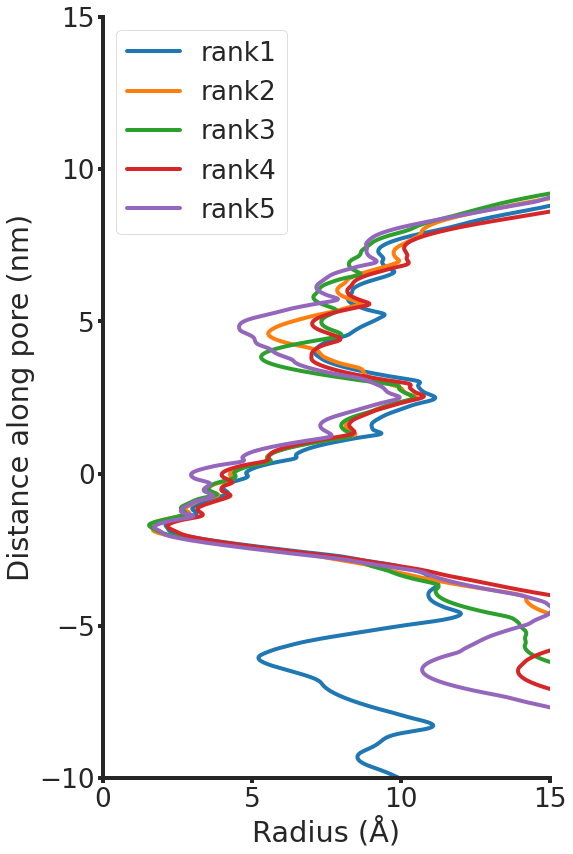

In [9]:
new_pdb_files = []
for pdb_file in pdb_files:
    new_pdb_files.append(clean_up_and_chap(pdb_file, nineprime=nineprime, get_chap=False))
print('Finished')
draw_pore_radius(location)

In [10]:
u = mda.Universe(new_pdb_files[0],*new_pdb_files)
aligner = align.AlignTraj(u, u, select='name CA', in_memory=True).run()
view = nv.show_mdanalysis(u)
view.camera = 'orthographic'

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [11]:
view

NGLWidget(max_frame=4)

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


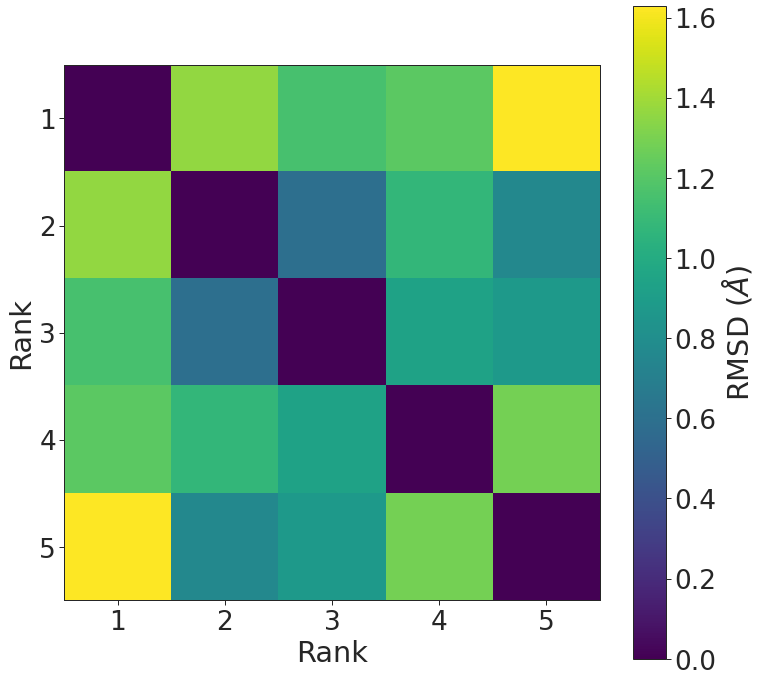

In [12]:
u_ensemble = [mda.Universe(new_pdb_file) for new_pdb_file in new_pdb_files]

for u in u_ensemble[1:]:
    align.alignto(u, u_ensemble[0], select='name CA and resid 81:300')

draw_pair_rmsd(u_ensemble)

## GABA pi

In [13]:
location = 'gaba_pi/predict/'
nineprime='resid 283 and name CA'

In [14]:
pdb_files = glob.glob(location + "rank_*_relaxed.pdb")
pdb_files.sort()
print(pdb_files)

['gaba_pi/predict/rank_1_model_3_seed_0_relaxed.pdb', 'gaba_pi/predict/rank_2_model_2_seed_0_relaxed.pdb', 'gaba_pi/predict/rank_3_model_4_seed_0_relaxed.pdb', 'gaba_pi/predict/rank_4_model_5_seed_0_relaxed.pdb', 'gaba_pi/predict/rank_5_model_1_seed_0_relaxed.pdb']


gaba_pi/predict/rank_1_model_3_seed_0_relaxed.pdb



/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


gaba_pi/predict/rank_2_model_2_seed_0_relaxed.pdb

gaba_pi/predict/rank_3_model_4_seed_0_relaxed.pdb

gaba_pi/predict/rank_4_model_5_seed_0_relaxed.pdb

gaba_pi/predict/rank_5_model_1_seed_0_relaxed.pdb

Finished


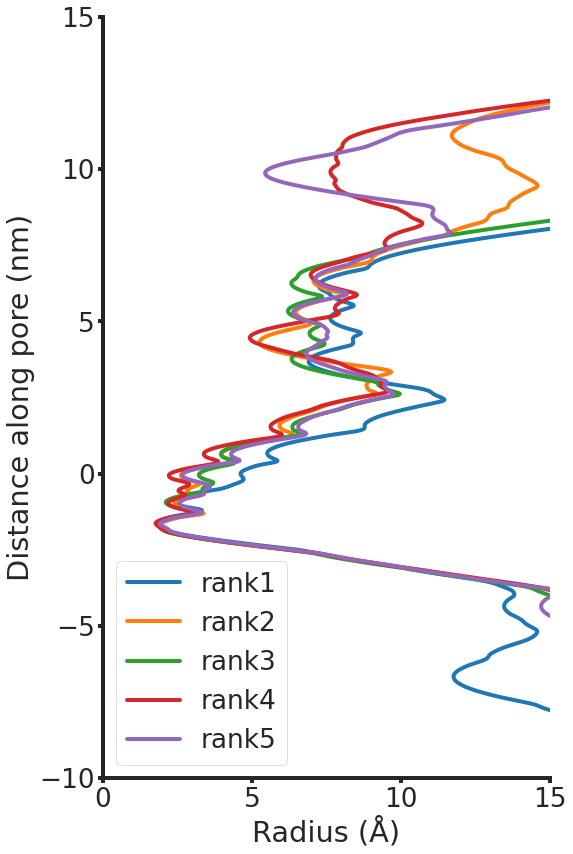

In [15]:
new_pdb_files = []
for pdb_file in pdb_files:
    new_pdb_files.append(clean_up_and_chap(pdb_file, nineprime=nineprime, get_chap=False))
print('Finished')
draw_pore_radius(location)

In [16]:
u = mda.Universe(new_pdb_files[0],*new_pdb_files)
aligner = align.AlignTraj(u, u, select='name CA', in_memory=True).run()
view = nv.show_mdanalysis(u)
view.camera = 'orthographic'

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [17]:
view

NGLWidget(max_frame=4)

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


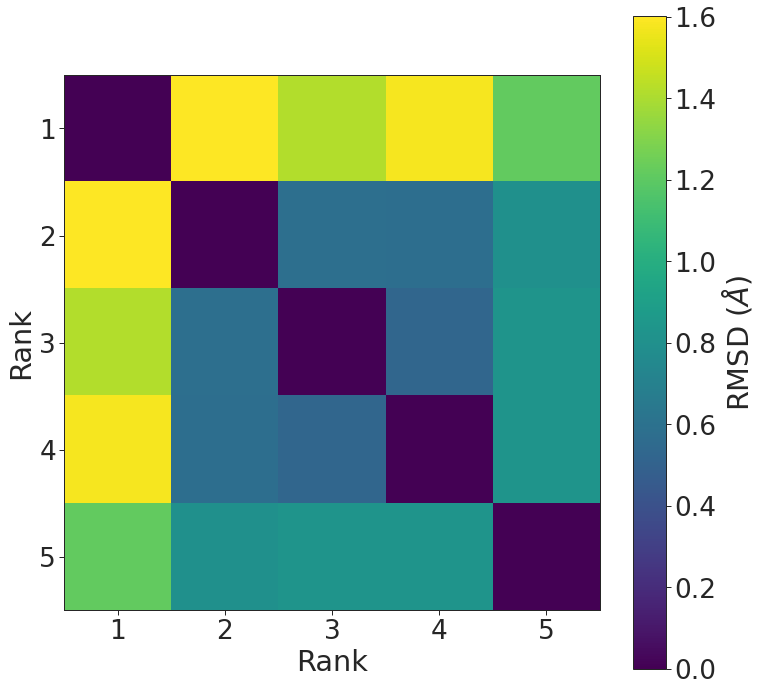

In [18]:
u_ensemble = [mda.Universe(new_pdb_file) for new_pdb_file in new_pdb_files]

for u in u_ensemble[1:]:
    align.alignto(u, u_ensemble[0], select='name CA and resid 81:300')

draw_pair_rmsd(u_ensemble)

## nAChR a7

In [19]:
location = 'a7_nachrs/predict/'
nineprime='resid 247 and name CA'

In [20]:
pdb_files = glob.glob(location + "rank_*_relaxed.pdb")
pdb_files.sort()
print(pdb_files)

['a7_nachrs/predict/rank_1_model_3_seed_0_relaxed.pdb', 'a7_nachrs/predict/rank_2_model_2_seed_0_relaxed.pdb', 'a7_nachrs/predict/rank_3_model_1_seed_0_relaxed.pdb', 'a7_nachrs/predict/rank_4_model_4_seed_0_relaxed.pdb', 'a7_nachrs/predict/rank_5_model_5_seed_0_relaxed.pdb']


a7_nachrs/predict/rank_1_model_3_seed_0_relaxed.pdb

a7_nachrs/predict/rank_2_model_2_seed_0_relaxed.pdb

a7_nachrs/predict/rank_3_model_1_seed_0_relaxed.pdb

a7_nachrs/predict/rank_4_model_4_seed_0_relaxed.pdb

a7_nachrs/predict/rank_5_model_5_seed_0_relaxed.pdb

Finished


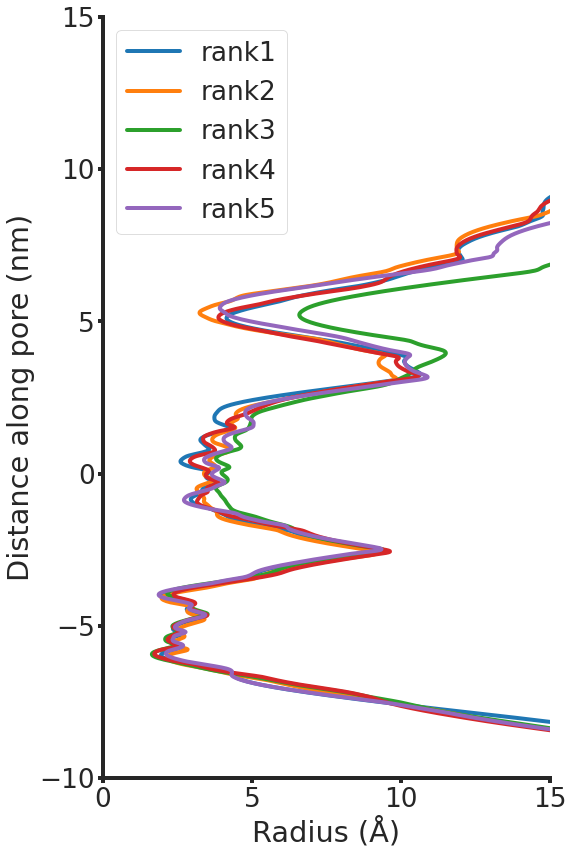

In [22]:
new_pdb_files = []
for pdb_file in pdb_files:
    new_pdb_files.append(clean_up_and_chap(pdb_file, nineprime=nineprime, get_chap=False))
print('Finished')
draw_pore_radius(location)

In [23]:
u = mda.Universe(new_pdb_files[1],*new_pdb_files)
aligner = align.AlignTraj(u, u, select='name CA', in_memory=True).run()
view = nv.show_mdanalysis(u)
view.camera = 'orthographic'
view

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


NGLWidget(max_frame=4)

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


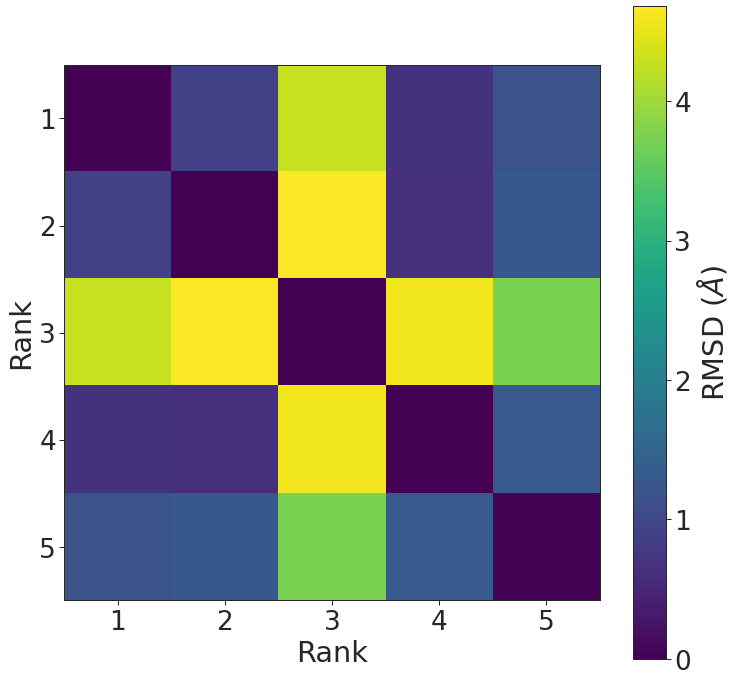

In [24]:
u_ensemble = [mda.Universe(new_pdb_file) for new_pdb_file in new_pdb_files]

for u in u_ensemble[1:]:
    align.alignto(u, u_ensemble[0], select='name CA and resid 81:300')

draw_pair_rmsd(u_ensemble)